In [1]:
# interactive figure
%matplotlib widget
# %matplotlib inline

In [2]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from sys import platform
from IPython.display import HTML, display
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from viztool import FormatScalarFormatter
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
from dask.distributed import LocalCluster, Client
# import dask.array as da
# import dask
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128

# def fxn():
#     warnings.warn('deprecated', DeprecationWarning)

In [3]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/FrontalZone/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/FrontalZone/Data/'
else:
    print('OS not supported.')

In [4]:
# for xr.map_blocks
# def func(obj, facet_width=64):
#     print(obj.sizes)
#     coarsened = obj.coarsen(xC=facet_width, yC=facet_width)
#     tilde = coarsened.mean()
#     facet = coarsened.construct(xC=('xC', 'xC_fine'), yC=('yC', 'yC_fine'))
#     prime = facet - tilde
#     wbt = (prime.w * prime.b).mean(['xC_fine', 'yC_fine']).rename('wbt')
#     wct = (prime.w * prime.c).mean(['xC_fine', 'yC_fine']).rename('wct')
#     wut = (prime.w * prime.u).mean(['xC_fine', 'yC_fine']).rename('wut')
#     wvt = (prime.w * prime.v).mean(['xC_fine', 'yC_fine']).rename('wvt')
#     uvt = (prime.u * prime.v).mean(['xC_fine', 'yC_fine']).rename('uvt')
#     ubt = (prime.u * prime.b).mean(['xC_fine', 'yC_fine']).rename('ubt')
#     uct = (prime.u * prime.c).mean(['xC_fine', 'yC_fine']).rename('uct')
#     dsc = xr.merge([tilde, wbt, wct, wut, wvt, uvt, ubt, uct])
#     return dsc#generate_grid_ds(dsc, {'x':'xC', 'y':'yC'}).rename({'xC_left':'xF', 'yC_left':'yF'})

In [ ]:
# dumvar = np.random.rand(315,64,8,8)
# dumds = xr.Dataset(
#     data_vars={'u': (['time','zC','yC','xC'], dumvar),
#                'v': (['time','zC','yC','xC'], dumvar),
#                'w': (['time','zC','yC','xC'], dumvar),
#                'b': (['time','zC','yC','xC'], dumvar),
#                'c': (['time','zC','yC','xC'], dumvar),
#              'wbt': (['time','zC','yC','xC'], dumvar),
#              'wct': (['time','zC','yC','xC'], dumvar),
#              'wut': (['time','zC','yC','xC'], dumvar),
#              'wvt': (['time','zC','yC','xC'], dumvar),
#              'uvt': (['time','zC','yC','xC'], dumvar),
#              'ubt': (['time','zC','yC','xC'], dumvar),
#              'uct': (['time','zC','yC','xC'], dumvar)},
#     coords={'time': dsf.time, 'zC': dsf.zC, 'zF': dsf.zF,
#             'yC': dsf.yC.coarsen(yC=64).mean(), 'xC': dsf.xC.coarsen(xC=64).mean()},
# ).chunk({'time':3, 'zC':16})
# dumds

# %%time
# mapped = xr.map_blocks(func, dsf, kwargs={'facet_width': 64}, template=dumds)
# mapped.compute()

In [ ]:
# dsf_facet.w.isel(time=100, zC=-6).plot(x='xC_fine', y='yC_fine', col='xC_coarse', row='yC_coarse', aspect=1.1, size=2)

In [4]:
from scipy import interpolate
def get_mld_ufunc(b, z, dsigma=5.4e-6):
    f = interpolate.interp1d(b, z, assume_sorted=False)
    mld = -f(b[-1]-dsigma)
    return mld

def get_mld(ds, criteria='b', dims=['zC']):
    a = ds[criteria]
    delta = 1e-5
    return xr.apply_ufunc(get_mld_ufunc, a, ds.zC,
                          input_core_dims=[dims, dims],
                          output_core_dims=[[]],
                          output_dtypes=[float],
                          kwargs=dict(dsigma=delta),
                          vectorize=True)

In [45]:
cname = 'f11_Q000_W037_D000_St0'

# dsf = xr.open_dataset(data_dir+cname+'_full.nc').chunk({'time':3,'zC':16})
# dsf.close()

dsafm = xr.open_dataset(data_dir+cname+'_afm.nc')
dsafm.close()
dsafm['timeTf'] = dsafm.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
dsafm['hb'] = get_mld(dsafm)
# dsafm['hq'] = get_mld(dsafm)

dsa = xr.open_dataset(data_dir+cname+'_averages.nc')#.drop_vars(['uym','vym','wym','bym','cym'])
dsa.close()
dsa['timeTf'] = dsa.time/np.timedelta64(int(np.around(2*np.pi/dsa.f)), 's')

### Horizontal velocity evolution

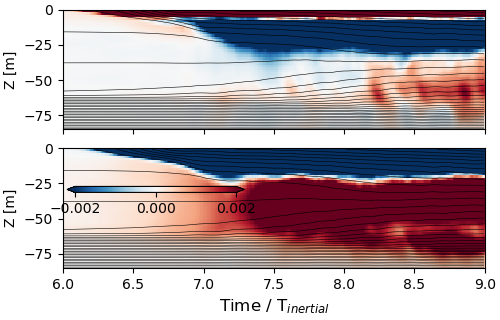

In [7]:
plt.close()
fig = plt.figure(figsize=(5,3.2), constrained_layout=True)
kw = dict(cmap='RdBu_r', vmin=-2e-3, vmax=2e-3)
bkw = dict(colors='k', linewidths=0.4)

fig.add_subplot(211)
plt.pcolormesh(dsafm.timeTf, dsafm.zC, dsafm.u.sel(xC=0, method='nearest').T, **kw);
plt.contour(dsafm.timeTf, dsafm.zC, dsafm.b.mean('xC').T, np.arange(0,2.5,0.02)*1e-4, **bkw)
# t = plt.text(6.1, -78, 'Wind', fontsize=10)
# t.set_bbox(boxkw)
plt.gca().set_xticklabels([])
plt.ylabel('Z [m]')
plt.ylim(-85,0);

fig.add_subplot(212)
plt.pcolormesh(dsafm.timeTf, dsafm.zC, dsafm.v.sel(xC=0, method='nearest').T, **kw);
plt.colorbar(orientation='horizontal', cax=plt.gca().inset_axes([0.01, 0.63, 0.42, 0.05]), extend='both');
plt.contour(dsafm.timeTf, dsafm.zC, dsafm.b.mean('xC').T, np.arange(0,2.5,0.02)*1e-4, **bkw)
# t = plt.text(6.1, -78, 'Wind', fontsize=10)
# t.set_bbox(boxkw)
plt.ylabel('Z [m]')
plt.ylim(-85,0);
plt.xlabel(r'Time / T$_{inertial}$', fontsize=12);

In [ ]:
plt.close()
plt.figure()

# tmp = dsafm.where(dsafm.timeTf<(6+np.sqrt(2)),drop=True).mean('xC')
# nc = tmp.sizes['time']
# colors = plt.cm.jet(np.linspace(0,1,nc))
# for i in range(0,nc,2):
#     u = tmp.u.isel(time=i,zC=slice(-40,None))
#     v = tmp.v.isel(time=i,zC=slice(-40,None))
#     plt.plot(u, v, c=colors[i], lw=1)
#     plt.scatter(u[-29], v[-29], 10, facecolor='none', edgecolor='k', lw=1)

# tmp = dsafm.where(dsafm.timeTf>(6+np.sqrt(2)),drop=True).mean('xC')
# nc = tmp.sizes['time']
# colors = plt.cm.RdGy(np.linspace(0,1,nc))
# for i in range(0,nc,2):
#     # u = tmp.u.isel(time=i,zC=slice(-40,None))
#     # v = tmp.v.isel(time=i,zC=slice(-40,None))
#     # plt.plot(u, v, c=colors[i], lw=1)
#     plt.scatter(u[-29], v[-29], 10, facecolor='none', edgecolor='k', lw=1)

# plt.scatter(dsf.u.sel(xC=0, yC=500, method='nearest').isel(zC=-12), 
#             dsf.v.sel(xC=0, yC=500, method='nearest').isel(zC=-12), 10, dsafm.timeTf, lw=1)

plt.axhline(0, c='k', ls='--', lw=1)
plt.axvline(0, c='k', ls='--', lw=1)
plt.gca().set_aspect('equal', 'box')
plt.grid('on', ls='--', lw=0.5)
# plt.colorbar()
plt.axis('equal');
# plt.xlim(-0.048, 0.048)
# plt.ylim(-0.048, 0.048);

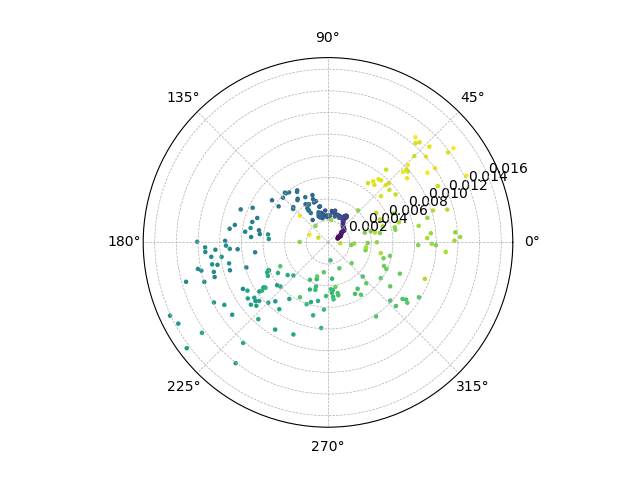

In [87]:
plt.close()
# plt.figure()

# tmp1 = tmp.where((tmp.u.isel(zC=-29)**2 + tmp.v.isel(zC=-29)**2)>=1e-6)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
iz=-15
plt.scatter(np.arctan2(dsf.v.sel(xC=0, yC=500, method='nearest').isel(zC=iz), dsf.u.sel(xC=0, yC=500, method='nearest').isel(zC=iz)), 
         np.sqrt(dsf.v.sel(xC=0, yC=500, method='nearest').isel(zC=iz)**2 +dsf.u.sel(xC=0, yC=500, method='nearest').isel(zC=iz)**2), 5, dsafm.timeTf)
plt.grid('on', ls='--', lw=0.5);

### Vertical flux

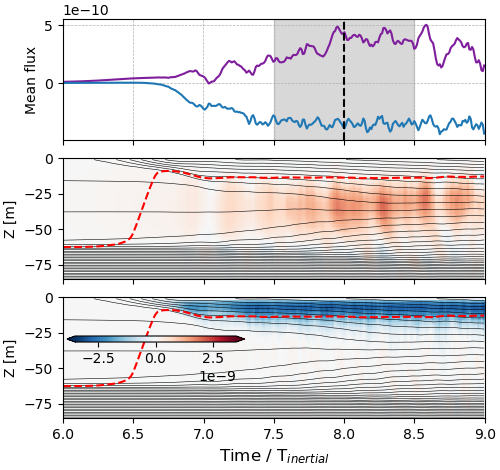

In [46]:
plt.close()
fig = plt.figure(figsize=(5,4.7), constrained_layout=True)
kw = dict(cmap='RdBu_r', vmin=-3.5e-9, vmax=3.5e-9)
bkw = dict(colors='k', linewidths=0.4)

wbs_tr = 8#dsafm.timeTf.isel(time=dsafm.wbs.mean(['zC','xC']).argmax(...)['time'])#7.53#.795
t0, t1 = wbs_tr-0.5, wbs_tr+0.5

fig.add_subplot(311)
plt.plot(dsafm.timeTf, dsafm.wbs.mean(['zC','xC']), 'xkcd:purple')
plt.plot(dsafm.timeTf, dsafm.wbt.mean(['zC','xC']), 'C0')
plt.axvline(wbs_tr, c='k', ls='--')
plt.axvspan(t0, t1, color='gray', alpha=0.3)
plt.grid('on', ls='--', lw=0.5)
plt.xlim(6,9)
plt.gca().set_xticklabels([])
plt.ylabel('Mean flux');

fig.add_subplot(312)
plt.pcolormesh(dsafm.timeTf, dsafm.zC, dsafm.wbs.mean('xC').T, **kw)
plt.contour(dsafm.timeTf, dsafm.zC, dsafm.b.mean('xC').T, np.arange(0,2.5,0.02)*1e-4, **bkw)
plt.plot(dsafm.timeTf, -dsafm.hb.mean('xC'), '--r')
# t = plt.text(6.1, -78, 'Wind', fontsize=10)
# t.set_bbox(boxkw)
plt.gca().set_xticklabels([])
plt.ylabel('Z [m]')
plt.ylim(-85,0);

fig.add_subplot(313)
plt.pcolormesh(dsafm.timeTf, dsafm.zC, dsafm.wbt.mean('xC').T, **kw)
plt.colorbar(orientation='horizontal', cax=plt.gca().inset_axes([0.01, 0.63, 0.42, 0.05]), extend='both')
plt.contour(dsafm.timeTf, dsafm.zC, dsafm.b.mean('xC').T, np.arange(0,2.5,0.02)*1e-4, **bkw)
plt.plot(dsafm.timeTf, -dsafm.hb.mean('xC'), '--r')
# t = plt.text(6.1, -78, 'Wind', fontsize=10)
# t.set_bbox(boxkw)
plt.ylabel('Z [m]')
plt.ylim(-85,0);
plt.xlabel(r'Time / T$_{inertial}$', fontsize=12);

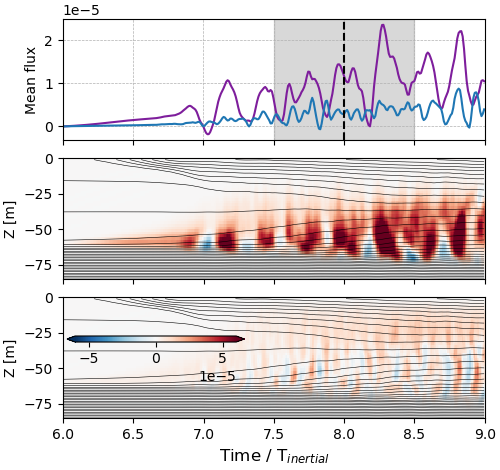

In [47]:
plt.close()
fig = plt.figure(figsize=(5,4.7), constrained_layout=True)
kw = dict(cmap='RdBu_r', vmin=-6e-5, vmax=6e-5)

# wcs_tr = dsafm.timeTf.isel(time=dsafm.wcs.mean(['zC','xC']).argmax(...)['time'])

fig.add_subplot(311)
plt.plot(dsafm.timeTf, dsafm.wcs.mean(['zC','xC']), 'xkcd:purple')
plt.plot(dsafm.timeTf, dsafm.wct.mean(['zC','xC']), 'C0')
plt.axvline(wbs_tr, c='k', ls='--')
plt.axvspan(t0, t1, color='gray', alpha=0.3)
plt.grid('on', ls='--', lw=0.5)
plt.xlim(6,9)
plt.gca().set_xticklabels([])
plt.ylabel('Mean flux');

fig.add_subplot(312)
plt.pcolormesh(dsafm.timeTf, dsafm.zC, dsafm.wcs.mean('xC').T, **kw);
plt.contour(dsafm.timeTf, dsafm.zC, dsafm.b.mean('xC').T, np.arange(0,2.5,0.02)*1e-4, **bkw)
# t = plt.text(6.1, -78, 'Wind', fontsize=10)
# t.set_bbox(boxkw)
plt.gca().set_xticklabels([])
plt.ylabel('Z [m]')
plt.ylim(-85,0);

fig.add_subplot(313)
plt.pcolormesh(dsafm.timeTf, dsafm.zC, dsafm.wct.mean('xC').T, **kw);
plt.colorbar(orientation='horizontal', cax=plt.gca().inset_axes([0.01, 0.63, 0.42, 0.05]), extend='both');
plt.contour(dsafm.timeTf, dsafm.zC, dsafm.b.mean('xC').T, np.arange(0,2.5,0.02)*1e-4, **bkw)
# t = plt.text(6.1, -78, 'Wind', fontsize=10)
# t.set_bbox(boxkw)
plt.ylabel('Z [m]')
plt.ylim(-85,0);
plt.xlabel(r'Time / T$_{inertial}$', fontsize=12);

In [48]:
time_interval = (dsafm.timeTf>=t0) & (dsafm.timeTf<t1)

xcr = int(dsafm.wbs.where(time_interval, drop=True).mean(['time', 'zC']).argmax(...)['xC'].data)
dsafm =dsafm.roll(xC=-(xcr-3))

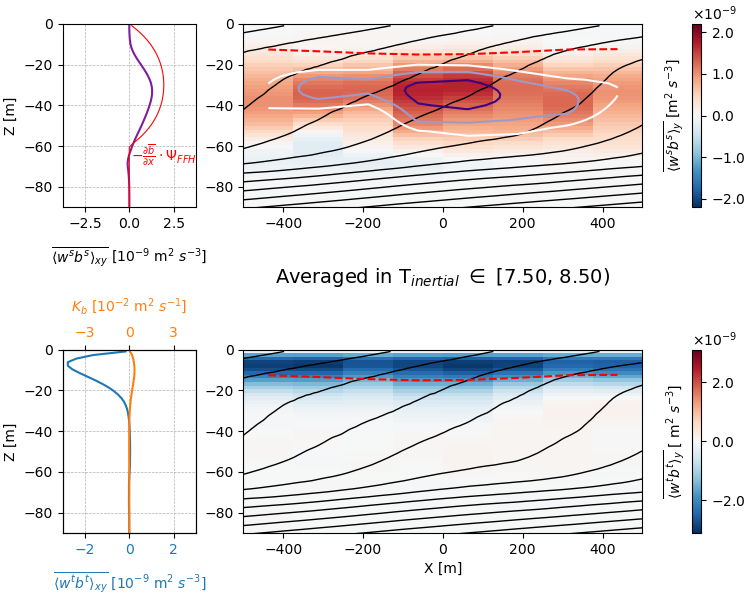

In [52]:
plt.close()
fig = plt.figure(figsize=(7.5,6), constrained_layout=True)
gs = gridspec.GridSpec(2, 4, figure=fig)
kw = {
      'cmap': 'RdBu_r',
      # 'norm': mcolors.CenteredNorm()
}
# wbs_tr = 7.95#dsafm.timeTf.isel(time=dsafm.wbs.mean(['zC','xC']).argmax(...)['time']).data

##### submesoscale scale flux #####
H = 60
mu = (1-(1+2*dsafm.zC/H)**2) * (1+5/21*(1+2*dsafm.zC/H)**2)
mu[dsafm.zC/H < -1] = 0
z_interval = dsafm.zC>=-H
dbdx = dsafm.dbadx.where(time_interval).mean('time') - dsa.attrs['M²']
dbdx_ml = dbdx.where(z_interval).mean(['zC','xC'])
psiFFH = -0.06*dbdx_ml*H**2/dsa.f * mu
wbs = dsafm.wbs.where(time_interval).mean('time')
psiHS = -wbs / dbdx
psim = np.ceil(1e2*psiHS.max().data)/1e2

H_new = 50
mu_new = (1-(1+2*(dsafm.zC+10)/H_new)**2) * (1+5/21*(1+2*(dsafm.zC+10)/H_new)**2)
mu_new[(dsafm.zC+10)/H_new < -1] = 0
mu_new[(dsafm.zC+10)/H_new > 0] = 0
z_interval_new = (dsafm.zC>=-60) & (dsafm.zC<=-10)
dbdx_ml_new = dbdx.where(z_interval_new).mean(['zC','xC'])
psi_new = -0.06*dbdx_ml_new*H_new**2/1e-4 * mu_new

ax1 = fig.add_subplot(gs[0, :1])
ax1.plot(1e9*wbs.mean('xC'), dsafm.zC, 'xkcd:purple')
ax1.plot(-1e9*dbdx_ml*psiFFH, dsafm.zC, 'r', lw=0.8)
# ax1.plot(-1e9*dbdx_ml_new*psi_new, dsafm.zC, '--g', lw=0.8)
ax1.grid('on', ls='--', lw=0.5)
ax1.set_xlim(-3.75,3.75)#-2.2, 2.2
ax1.set_ylabel('Z [m]')
ax1.text(0.51, 0.25, r'$-\frac{\partial \overline{b}}{\partial x} \cdot \Psi_{FFH}$', transform=ax1.transAxes, color='r')
ax1.set_xlabel(r'$\overline{\langle w^s b^s\rangle_{xy}}$ [10$^{-9}$ m$^2$ $s^{-3}$]', labelpad=10)
ax1.set_ylim(-90,0)

ax2 = fig.add_subplot(gs[0, 1:], sharey=ax1)
Cs = ax2.pcolormesh(dsafm.xC, dsafm.zC, wbs, vmin=-2.2e-9, vmax=2.2e-9, **kw)
ax2.contour(dsa.xC, dsa.zC, dsa.bym.where(time_interval).mean('time') - dsa.attrs['M²']*dsa.xC,
            np.arange(0,2.2,0.08)*1e-4, colors='k', linewidths=1)
ax2.contour(dsafm.xC, dsafm.zC, psiHS, np.arange(0.03,psim,0.01), cmap='Purples', linewidths=1.5)
ax2.plot(dsafm.xC, -dsafm.hb.where(time_interval).mean('time'), '--r')
cbar1 = fig.colorbar(Cs, ax=ax2, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.1f'))
cbar1.set_label(r'$\overline{\langle w^s b^s\rangle_{y}}$ [m$^2$ $s^{-3}$]', labelpad=-60)
cbar1.formatter.set_powerlimits((0, 0))
cbar1.formatter.set_useMathText(True)
cbar1.ax.yaxis.set_offset_position('left')
ax2.set_xlabel(rf'Averaged in T$_{{inertial}}$ $\in$ [{t0:.2f}, {t1:.2f})', fontsize=14, labelpad=25);

##### fine scale flux #####
wbt = dsafm.wbt.where(time_interval).mean('time')
dbdz = dsafm.dbadz.where(time_interval).mean(['time','xC'])
Kb = -wbt.mean('xC') / dbdz
# Kb = - (dsafm.wbt.where(time_interval) / dsafm.dbadz.where(time_interval)).mean(['time','xC'])

ax3 = fig.add_subplot(gs[1, :1])
color='C0'
ax3.plot(1e9*wbt.mean('xC'), dsafm.zC)
ax3.grid('on', ls='--', lw=0.5)
ax3.set_xlim(-3,3)
ax3.set_ylabel('Z [m]')
ax3.set_xlabel(r'$\overline{\langle w^t b^t\rangle_{xy}}$ [10$^{-9}$ m$^2$ $s^{-3}$]', labelpad=10, color=color)
ax3.tick_params(axis='x', labelcolor=color)
ax3.set_ylim(-90,0)

ax3k = ax3.twiny()
color = 'C1'
ax3k.plot(Kb*1e2, dsafm.zC, color=color)
# ax3k.axvline(0.04*np.sqrt(0.037/1026)*25*1e2, c='r')
ax3k.set_xlim(-4.5,4.5)
ax3k.set_xlabel(r'$K_b$ [10$^{-2}$ m$^2$ $s^{-1}$]', labelpad=10, color=color)
ax3k.set_xticks([-3, 0, 3])
# ax3k.text(0.51, 0.25, r'0.04 u$_*$h', transform=ax3k.transAxes, color='r')
ax3k.tick_params(axis='x', labelcolor=color)

ax4 = fig.add_subplot(gs[1, 1:], sharey=ax3, sharex=ax2)
Ct = ax4.pcolormesh(dsafm.xC, dsafm.zC, wbt, vmin=-3.1e-9, vmax=3.1e-9, **kw)
ax4.contour(dsa.xC, dsa.zC, dsa.bym.where(time_interval).mean('time') - dsa.attrs['M²']*dsa.xC,
            np.arange(0,2.2,0.08)*1e-4, colors='k', linewidths=1)
ax4.plot(dsafm.xC, -dsafm.hb.where(time_interval).mean('time'), '--r')
cbar2 = fig.colorbar(Ct, ax=ax4, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.1f'))
cbar2.set_label(r'$\overline{\langle w^t b^t\rangle_{y}}$ [ m$^2$ $s^{-3}$]', labelpad=-60)
cbar2.formatter.set_powerlimits((0, 0))
cbar2.formatter.set_useMathText(True)
cbar2.ax.yaxis.set_offset_position('left')
ax4.set_xlabel('X [m]');

# plt.savefig('../Figures/wbs_wbt_Psi_K_E.png', bbox_inches='tight', dpi=200);

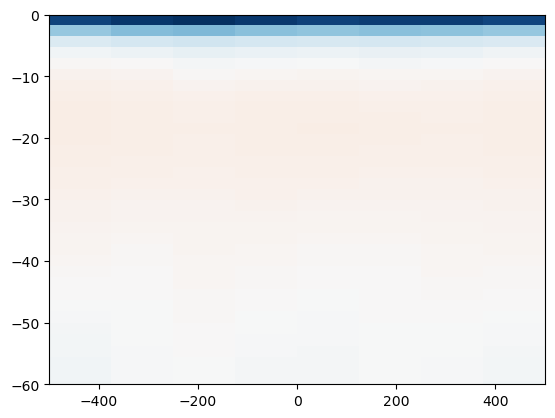

In [13]:
plt.close()
plt.figure()
kw = {
      'cmap': 'RdBu_r',
      'norm': mcolors.CenteredNorm()
}

plt.pcolormesh(dsafm.xC, dsafm.zC, (dsafm.u*dsafm.b).where(time_interval).mean('time'), **kw)
plt.ylim(-60,0);

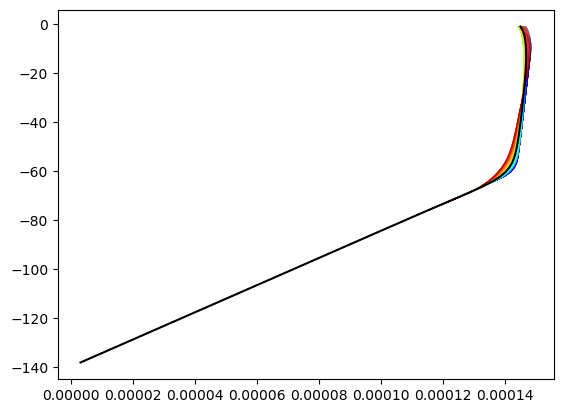

In [16]:
plt.close()
plt.figure()
time_interval = (dsafm.timeTf>=t0) & (dsafm.timeTf<t1)


tmp = dsafm.b.where(time_interval, drop=True).mean(['xC'])
nc = tmp.sizes['time']
colors = plt.cm.jet(np.linspace(0,1,nc))
for i in range(nc):
    plt.plot(tmp.isel(time=i).T, dsafm.zC, lw=0.2, color=colors[i]);
plt.plot(tmp.mean(['time']).T, dsafm.zC, 'k');

# plt.plot(np.abs(dsafm.wbt.where(time_interval,drop=True).mean(['xC','time'])/dsafm.dbadz.where(time_interval,drop=True).mean(['xC','time'])), dsafm.zC);
# plt.plot(dsafm.dbadz.where(time_interval,drop=True).mean('xC').T, dsafm.zC);
# plt.ylim(-60,0)

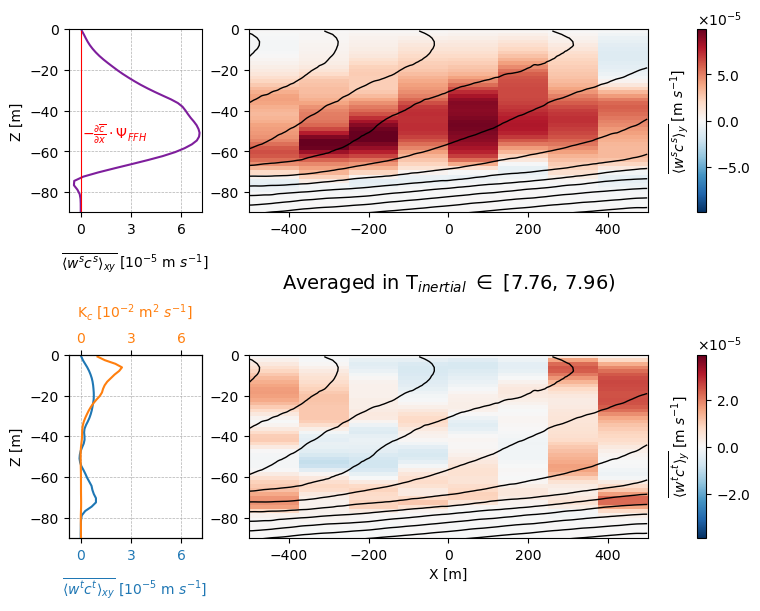

In [54]:
plt.close()
fig = plt.figure(figsize=(7.5,6), constrained_layout=True)
gs = gridspec.GridSpec(2, 4, figure=fig)
kw = {
      'cmap': 'RdBu_r',
      # 'norm': mcolors.CenteredNorm()
}
# wbs_tr = 7.95#dsafm.timeTf.isel(time=dsafm.wbs.mean('zC').argmax(...)['time']).round(2).data
t0, t1 = wbs_tr-0.1, wbs_tr+0.1
time_interval = (dsafm.timeTf>=t0) & (dsafm.timeTf<t1)

##### submesoscale scale flux #####
# H = 60
# mu = (1-(1+2*dsafm.zC/60)**2) * (1+5/21*(1+2*dsafm.zC/60)**2)
# mu[dsafm.zC/60 < -1] = 0
# z_interval = dsafm.zC>=-60
dcdx = dsafm.dcadx.where(time_interval).mean('time')
dcdx_ml = dcdx.where(z_interval).mean(['xC','zC'])
# psiFFH = -0.06*dbdx_ml*H**2/1e-4 * mu
wcs = dsafm.wcs.where(time_interval).mean('time')
# psiHS = -wbs / dbdx

# H_new = 50
# mu_new = (1-(1+2*(dsafm.zC+10)/H_new)**2) * (1+5/21*(1+2*(dsafm.zC+10)/H_new)**2)
# mu_new[(dsafm.zC+10)/H_new < -1] = 0
# mu_new[(dsafm.zC+10)/H_new > 0] = 0
# z_interval_new = (dsafm.zC>=-60) & (dsafm.zC<=-10)
# dbdx_ml_new = dbdx.where(z_interval_new).mean(['xC','zC'])
# psi_new = -0.06*dbdx_ml_new*H_new**2/1e-4 * mu_new

ax1 = fig.add_subplot(gs[0, :1])
ax1.plot(1e5*wcs.mean('xC'), dsafm.zC, 'xkcd:purple', label='_nolegend_')
ax1.plot(-dcdx_ml*psiFFH, dsafm.zC, 'r', lw=0.8, label=r'$-\frac{\partial c}{\partial x} \cdot \Psi_{FFH}$')
# ax1.plot(-dbdx_ml_new*psi_new, dsafm.zC, '--g', lw=0.8, label='_nolegend_')
ax1.grid('on', ls='--', lw=0.5)
ax1.set_xlim(-0.72,7.2)
ax1.set_xticks([0, 3, 6])
ax1.set_ylabel('Z [m]')
ax1.text(0.1, 0.4, r'$-\frac{\partial \overline{c}}{\partial x} \cdot \Psi_{FFH}$', transform=ax1.transAxes, color='r')
ax1.set_xlabel(r'$\overline{\langle w^s c^s\rangle_{xy}}$ [10$^{-5}$ m $s^{-1}$]', labelpad=10)
ax1.set_ylim(-90,0)

ax2 = fig.add_subplot(gs[0, 1:], sharey=ax1)
Cs = ax2.pcolormesh(dsafm.xC, dsafm.zC, wcs, vmin=-9.9e-5, vmax=9.9e-5, **kw)
ax2.contour(dsa.xC, dsa.zC, dsa.bym.where(time_interval).mean('time') - dsa.attrs['M²']*dsa.xC,
            np.arange(0,2.2,0.08)*1e-4, colors='k', linewidths=1)
# ax2.contour(dsafm.xC, dsafm.zC, psiHS, np.arange(0,0.04,0.005), cmap='Purples', linewidths=1.5)
cbar1 = fig.colorbar(Cs, ax=ax2, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.1f'))
cbar1.set_label(r'$\overline{\langle w^s c^s\rangle_{y}}$ [m $s^{-1}$]', labelpad=-60)
cbar1.formatter.set_powerlimits((0, 0))
cbar1.formatter.set_useMathText(True)
cbar1.ax.yaxis.set_offset_position('left')
ax2.set_xlabel(rf'Averaged in T$_{{inertial}}$ $\in$ [{t0:.2f}, {t1:.2f})', fontsize=14, labelpad=25);

##### fine scale flux #####
wct = dsafm.wct.where(time_interval).mean('time')
dcdz = dsafm.dcadz.where(time_interval).mean(['time','xC'])
Kc = -wct.mean('xC') / dcdz

ax3 = fig.add_subplot(gs[1, :1])
color='C0'
ax3.plot(1e5*wct.mean('xC'), dsafm.zC)
ax3.grid('on', ls='--', lw=0.5)
ax3.set_xlim(-0.72,7.2)
ax3.set_xticks([0, 3, 6])
ax3.set_ylabel('Z [m]')
ax3.set_xlabel(r'$\overline{\langle w^t c^t\rangle_{xy}}$ [10$^{-5}$ m $s^{-1}$]', labelpad=10, color=color)
ax3.tick_params(axis='x', labelcolor=color)
ax3.set_ylim(-90,0)

ax3k = ax3.twiny()
color = 'C1'
ax3k.plot(Kc*1e2, dsafm.zC, color=color)
ax3k.set_xlim(-0.72,7.2)
ax3k.set_xticks([0, 3, 6])
ax3k.set_xlabel(r'K$_c$ [10$^{-2}$ m$^2$ $s^{-1}$]', labelpad=10, color=color)
ax3k.tick_params(axis='x', labelcolor=color)

ax4 = fig.add_subplot(gs[1, 1:], sharey=ax3, sharex=ax2)
Ct = ax4.pcolormesh(dsafm.xC, dsafm.zC, wct, vmin=-3.9e-5, vmax=3.9e-5, **kw)
ax4.contour(dsa.xC, dsa.zC, dsa.bym.where(time_interval).mean('time') - dsa.attrs['M²']*dsa.xC,
            np.arange(0,2.2,0.08)*1e-4, colors='k', linewidths=1)
cbar2 = fig.colorbar(Ct, ax=ax4, fraction=0.5, pad=0.05, format=FormatScalarFormatter('%.1f'))
cbar2.set_label(r'$\overline{\langle w^t c^t\rangle_{y}}$ [m $s^{-1}$]', labelpad=-60)
cbar2.formatter.set_powerlimits((0, 0))
cbar2.formatter.set_useMathText(True)
cbar2.ax.yaxis.set_offset_position('left')
ax4.set_xlabel('X [m]');

# plt.savefig('../Figures/wcs_wct_Psi_K_E.png', bbox_inches='tight', dpi=200);

In [24]:
clist = ['f11_Q000_W000_D000_St0',
         'f11_Q000_W037_D000_St0',
         'f11_Q000_W037_D090_St0',
         'f11_Q000_W037_D180_St0',
         'f11_Q000_W037_D270_St0',
         'n11_Q000_W037_D000_St0']
dsd = []
for cname in clist:
    dsafm = xr.open_dataset(data_dir+cname+'_afm.nc')
    dsafm.close()
    dsafm['timeTf'] = dsafm.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
    dsafm['hb'] = get_mld(dsafm)
    ds = dsafm.where((dsafm.timeTf>=7.5) & (dsafm.timeTf<8.5)).mean(['time','xC'])
    dsd.append(ds)
dsd = xr.concat(dsd, pd.Index(clist, name='case'))

In [25]:
dsd['Kb'] = -dsd.wbt / dsd.dbadz
dsd['Kc'] = -dsd.wct / dsd.dcadz

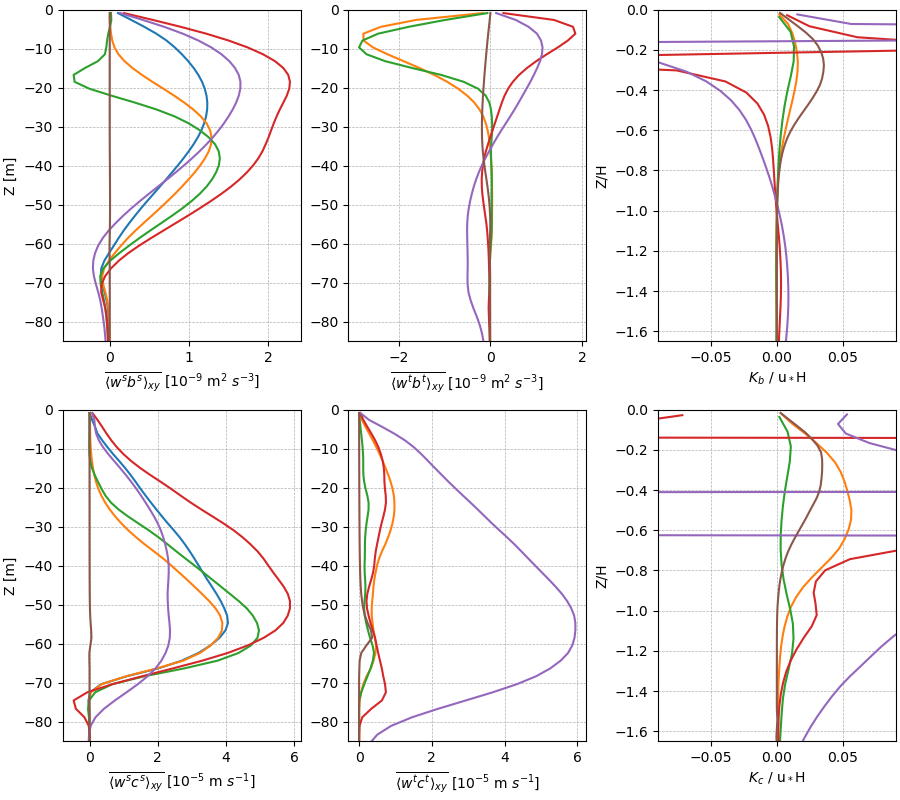

In [26]:
plt.close()
plt.figure(figsize=(9,8), constrained_layout=True)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.subplot(2,3,1)
plt.plot(1e9*dsd.wbs.T, dsd.zC)
plt.grid('on', ls='--', lw=0.5)
plt.xlabel(r'$\overline{\langle w^s b^s\rangle_{xy}}$ [10$^{-9}$ m$^2$ $s^{-3}$]')
plt.ylabel('Z [m]')
plt.ylim(-85, 0);

plt.subplot(2,3,2)
for i in range(1,dsd.sizes['case']):
    plt.plot(1e9*dsd.wbt.isel(case=i), dsd.zC, c=cycle_colors[i])
plt.grid('on', ls='--', lw=0.5)
plt.xlabel(r'$\overline{\langle w^t b^t\rangle_{xy}}$ [10$^{-9}$ m$^2$ $s^{-3}$]')
plt.ylim(-85, 0);

plt.subplot(2,3,3)
for i in range(1,dsd.sizes['case']):
    plt.plot(dsd.Kb.isel(case=i)/np.sqrt(0.037/1026)/dsd_h[i],#dsd.hb.isel(case=i), 
             dsd.zC/dsd_h[i], c=cycle_colors[i])
plt.grid('on', ls='--', lw=0.5)
plt.xlabel(r'$K_b$ / u$_*$H')
plt.ylabel('Z/H')
plt.xlim(-0.09, 0.09)
plt.ylim(-1.65, 0);

plt.subplot(2,3,4)
plt.plot(1e5*dsd.wcs.T, dsd.zC)
plt.grid('on', ls='--', lw=0.5)
plt.xlabel(r'$\overline{\langle w^s c^s\rangle_{xy}}$ [10$^{-5}$ m $s^{-1}$]')
plt.ylabel('Z [m]')
plt.ylim(-85, 0);

plt.subplot(2,3,5)
for i in range(1,dsd.sizes['case']):
    plt.plot(1e5*dsd.wct.isel(case=i), dsd.zC, c=cycle_colors[i])
plt.grid('on', ls='--', lw=0.5)
plt.xlabel(r'$\overline{\langle w^t c^t\rangle_{xy}}$ [10$^{-5}$ m $s^{-1}$]')
plt.ylim(-85, 0);

plt.subplot(2,3,6)
for i in range(1,dsd.sizes['case']):
    plt.plot(dsd.Kc.isel(case=i)/np.sqrt(0.037/1026)/dsd_h[i],#dsd.hb.isel(case=i), 
             dsd.zC/dsd_h[i], c=cycle_colors[i])
plt.grid('on', ls='--', lw=0.5)
plt.xlabel(r'$K_c$ / u$_*$H')
plt.ylabel('Z/H')
plt.xlim(-0.09, 0.09)
plt.ylim(-1.65, 0);

In [19]:
dsd_h = np.array([60, 37, 24, 32, 37, 54])